I denne notebook findes koden, som blev benyttet i afhandlingens del II om sk√¶bnebegrebet i det moderne gennembrud.

Notebook'en tager udgangspunkt i "Training and Fine-Tuning BERT for Classification: Classifying Goodreads Reviews By Book Genre", en notebook, som projektet ‚Äì og en i √∏vrigt meget anbefalelsv√¶rdig ressource ‚Äì [AI for Humanists](https://aiforhumanists.com/tutorials/) p√• Cornell University har stillet r√•dighed.

Forud for tekstklassifikationen blev datas√¶ttet etableret ved hj√¶lp af biblioteket [spaCy](https://spacy.io/models/da) og den danske NLP-pipeline *da_core_news_md*, hvor sentence segmentation blev benyttet til at finde udtr√¶kke ni af modellen identificerede s√¶tninger rundt om n√∏gleordet: *sk√¶bne*. F√∏lgende regul√¶re udtryk blev benyttet ([a-z√¶√∏√•]\*)(sk[j]?√¶bne)([a-z√¶√∏√•]\*) og ([a-z√¶√∏√•]\*)(sk[j]?ebne)([a-z√¶√∏√•]\*), som fanger alle forekomster af ordet ‚Äôsk√¶bne‚Äô inklusiv b√∏jninger, afledninger og sammens√¶tninger. Sidstn√¶vnte betyder, at ord som fx "sk√¶bnesvanger" og "vansk√¶bne" ogs√• indg√•r i datas√¶ttet.

# Install√©r om import√©r biblioteker og pakker

In [ ]:
!pip install transformers
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install torch
!pip install datasets
!pip install xformers

In [ ]:
from collections import defaultdict
import random
import pickle
import torch

import os

import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForTokenClassification
from transformers import Trainer, TrainingArguments
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.auto import tqdm
from datasets import Dataset

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
sns.set(style='ticks', font_scale=1.2)
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Indl√¶s data

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

dataset = gc.open('sk√¶bne_datas√¶t').sheet1
rows = dataset.get_all_values()
df = pd.DataFrame(rows)

df.columns = df.iloc[0]
df = df.iloc[1:]
df

0     index                                     file_name  \
1       299                    1896_Lundgaard_DonJuan.txt   
2      2153  1882_Winterhjelm_TilStatsraadstaburetten.txt   
3     16395        1878_SoerensenC_AltForFaedrelandet.txt   
4      1075       1881_CS_NogleDageAfEnPolitimandsLiv.txt   
5      3786                 1871_L.F._Capercapitainen.txt   
...     ...                                           ...   
8088   1132                  1888_EwaldHF_Griffenfeld.txt   
8089    832                       1873_EwaldHF_Agathe.txt   
8090   5638                 1877_EwaldHF_NielsBrahe_2.txt   
8091   2954             1888_Trafall_KjaempendeMagter.txt   
8092   3521               1881_EwaldHF_GeorgReinfeldt.txt   

0                                               segment label  
1     Saa gik D√∏ren op , og den Porcell√¶ns√∏jede \nvi...     2  
2     Det kan v√¶re , at det ikke er hendes Skyld , \...     3  
3     ‚Äú \n‚Äû Jeg gifter mig aldrig paany . ‚Äú \n‚Äû Man ...     1  
4     Tredie Kapitel . \n En stakkels forladt Kone ....     2  
5     Landmanden tilkjendegav ham , at hvis han \n√∏n...     2  
...                                                 ...   ...  
8088  Saa lod han \nsig oph√∏ie i Adelstanden og anto...        
8089  Deri var nu ingen \nUlykke , uagtet Broderens ...        
8090  For \nat see Eder og Niels Nielsen komme , gik...        
8091  Der er intet i \nverden , jeg foragter saa som...        
8092  Han formaaede vistnok \nikke at give alle de T...        

[8092 rows x 4 columns]

Datas√¶ttet deles i to dataframes, dvs. √©n annoteret og √©n uannoteret, som eftef√∏lgende f√•r nye indekser.


In [ ]:
split_index = 650
labeled_df = df.iloc[:split_index].reset_index(drop=True)
unlabeled_df = df.iloc[split_index:].reset_index(drop=True)

In [ ]:
labeled_df

0    index                                          file_name  \
0      299                         1896_Lundgaard_DonJuan.txt   
1     2153       1882_Winterhjelm_TilStatsraadstaburetten.txt   
2    16395             1878_SoerensenC_AltForFaedrelandet.txt   
3     1075            1881_CS_NogleDageAfEnPolitimandsLiv.txt   
4     3786                      1871_L.F._Capercapitainen.txt   
..     ...                                                ...   
645   4994                    1894_Schumacher_AgneteBudde.txt   
646   1745  1870_Anonym_StokhusslavenSoerenVintyvEllerForb...   
647   9458           1874_Nordrup_KongValdemarOgTovelille.txt   
648    750                               1882_LieJ_GaaPaa.txt   
649   2137                  1890_EwaldHF_CarolineMathilde.txt   

0                                              segment label  
0    Saa gik D√∏ren op , og den Porcell√¶ns√∏jede \nvi...     2  
1    Det kan v√¶re , at det ikke er hendes Skyld , \...     3  
2    ‚Äú \n‚Äû Jeg gifter mig aldrig paany . ‚Äú \n‚Äû Man ...     1  
3    Tredie Kapitel . \n En stakkels forladt Kone ....     2  
4    Landmanden tilkjendegav ham , at hvis han \n√∏n...     2  
..                                                 ...   ...  
645  Det var pudsigt af iagttage Minerne hos dem , ...     0  
646  Hans Navn er Adolf Skou , og han √∏r j√¶vnaldren...     1  
647  . Under hendes Vindue stod Du \nmed din Streng...     3  
648  stod igjen h√∏jlig h√¶vet i sin Bevidsthed \nved...     1  
649  Hovedet fortumlet af denne Aftens sk√¶bnesvangr...     3  

[650 rows x 4 columns]

In [ ]:
unlabeled_df

0     index                                          file_name  \
0     16492  1883_FT_TugthusfangenHannibalOgDenSmukkeRosali...   
1        56                             1871_Behrend_Hulda.txt   
2      1778                         1870_Lange_AaenOgHavet.txt   
3      1761                    1884_Ravnkilde_JudithFurste.txt   
4      7599            1877_RygaardHa_PerlefiskerensSoen_1.txt   
...     ...                                                ...   
7437   1132                       1888_EwaldHF_Griffenfeld.txt   
7438    832                            1873_EwaldHF_Agathe.txt   
7439   5638                      1877_EwaldHF_NielsBrahe_2.txt   
7440   2954                  1888_Trafall_KjaempendeMagter.txt   
7441   3521                    1881_EwaldHF_GeorgReinfeldt.txt   

0                                               segment label  
0     Jeg priser \nSk√¶bnen , som atter har spillet d...        
1     Dette Gods tilh√∏rer Grev Tadlos , en spansk Ad...        
2     ligeoverfor hende \nsom overfor Andre . Det va...        
3     Det er den fornuftigste Handling , \nhan har f...        
4     Dig for af forelske Dig \n i en Kvinde ! . . ....        
...                                                 ...   ...  
7437  Saa lod han \nsig oph√∏ie i Adelstanden og anto...        
7438  Deri var nu ingen \nUlykke , uagtet Broderens ...        
7439  For \nat see Eder og Niels Nielsen komme , gik...        
7440  Der er intet i \nverden , jeg foragter saa som...        
7441  Han formaaede vistnok \nikke at give alle de T...        

[7442 rows x 4 columns]

Her indl√¶ses romanenernes metadata og tilpasses korpusset.


In [ ]:
metadata = pd.read_excel('/content/drive/MyDrive/Notebooks_and_data/MeMo-corpus-metadata-v1.1-2023-06-20.xlsx')

In [ ]:
metadata_of_interest = ["filename", "firstname", "surname", "pseudonym", "gender", "nationality", "title", "subtitle", "year", "pages", "typeface", "publisher", "price"]

metadata_df = metadata[metadata_of_interest]

metadata_df['filename'] = metadata_df['filename'].str.replace('.pdf', '.txt')

In [ ]:
dir_path = "/content/drive/MyDrive/Notebooks_and_data/romankorpus.v1.0_w_OCR_error_corrections"

txt_files = [file for file in os.listdir(dir_path) if file.endswith(".txt")]

metadata_filenames = metadata_df['filename'].tolist()

missing_files = [filename for filename in metadata_filenames if filename not in txt_files]

metadata_df = metadata_df[~metadata_df['filename'].isin(missing_files)]


In [ ]:
metadata_df['gender'] = metadata_df['gender'].fillna('ukendt')
metadata_df['nationality'] = metadata_df['nationality'].fillna('ukendt')
metadata_df['price'] = metadata_df['price'].fillna('ukendt')
replacement_dict = {'na': 'ukendt', '(se note)': 'ukendt'}
metadata_df['price'] = metadata_df['price'].replace(replacement_dict)

In [ ]:
metadata_df

filename    firstname   surname  \
0                        1870_AndersenHC_LykkePeer.txt         H.C.  Andersen   
2                     1870_Brosboell_TranensVarsel.txt         Carl  Brosb√∏ll   
3                          1870_Dodt_AegteOgUaegte.txt       Beatus      Dodt   
4                       1870_Friis_MoedetPaaLaesoe.txt       J.J.F.     Friis   
5                        1870_Friis_MagnusHeinesen.txt       J.J.F.     Friis   
..                                                 ...          ...       ...   
908                             1899_Tuxen_Hvorfor.txt        Fanny     Tuxen   
909             1879_Anselmo_AmelieEllerLivIDoeden.txt          NaN       NaN   
911                       1899_Wied_LivsensOndskab.txt       Gustav      Wied   
912                  1899_WintherH_PaaFremmedGrund.txt      Hedevig   Winther   
913  1899_Worm_ForbrydelsernesKongeEllerDenSkalpere...  Peter Anton      Worm   

             pseudonym gender nationality  \
0                  NaN      m          dk   
2          Carit Etlar      m          dk   
3                  NaN      m          dk   
4                  NaN      m          dk   
5                  NaN      m          dk   
..                 ...    ...         ...   
908                NaN      f          dk   
909  Viktor de Anselmo    NaN         NaN   
911                NaN      m          dk   
912                NaN      f          dk   
913             anonym      m          dk   

                                                title  \
0                                          Lykke-Peer   
2                                      Tranens Varsel   
3                                       √Ügte og U√¶gte   
4                                      M√∏det paa L√¶s√∏   
5                                     Magnus Heinesen   
..                                                ...   
908                                          Hvorfor?   
909                          Amelie eller Liv i D√∏den   
911                                   Livsens Ondskab   
912                                 Paa fremmed Grund   
913  Forbrydelsernes Konge eller Den skalperede Pr√¶st   

                                          subtitle  year  pages typeface  \
0                                              NaN  1870  183.0   gothic   
2                                         En Roman  1870  528.0   gothic   
3                                      Livsbillede  1870  517.0   gothic   
4                                    En Fort√¶lling  1870  164.0   gothic   
5                               En historisk Roman  1870  209.0   gothic   
..                                             ...   ...    ...      ...   
908                                     Fort√¶lling  1899  187.0    roman   
909  Efter en afd√∏d Jordemoders Meddelelser. Roman  1879  480.0   gothic   
911                      Billeder fra Gammelk√∏bing  1899  390.0    roman   
912                                     Fort√¶lling  1899  180.0    roman   
913                                            NaN  1899  888.0    roman   

                        publisher price  
0                         Reitzel  2.25  
2                Chr. Steen & S√∏n   5.5  
3                Chr. Steen & S√∏n  5.35  
4                Chr. Steen & S√∏n  1.85  
5                Chr. Steen & S√∏n  2.35  
..                            ...   ...  
908                      Hagerup    2.5  
909  Lohmannske Forlagsforretning     3  
911                     Gyldendal   5.5  
912                   Jens M√∏ller  2.25  
913              Emil F. Petersen   3.3  

[839 rows x 13 columns]

# Finjustering af model

## Klarg√∏ring af data

Her splittes den annoterede dataframe i et tr√¶ningss√¶t og et tests√¶t til finjusteringen af modellen. 80% af segmenterne bruges til tr√¶ning, mens 20% bruges til test.
Da datas√¶ttet ikke er balanceret, anvendes et stratificeret split, der tager h√∏jde for den uj√¶vne distribution af kategorier.
Jeg har brugt `random_state` parameteret til at sikre et reproducerbart split, som tilgodeser de kategorier, jeg er s√¶rligt interesseret i, nemlig f√∏rmoderne og moderne sk√¶bneopfattelser.

In [ ]:
X = labeled_df['segment']
y = labeled_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, stratify=y, random_state=6)
train_data = pd.DataFrame({'label': y_train, 'segment': X_train})
test_data = pd.DataFrame({'label': y_test, 'segment': X_test})

Her benyttes en dictionary til at forbinde hver annotationsv√¶rdi med en liste af segmenter, som har den p√•g√¶ldende annotationsv√¶rdi. Efterf√∏glende overs√¶ttes annotationerne fra numeriske v√¶rdier til tekst-etiketter. Resultatet er en ny dictionary med de opdaterede annotationsv√¶rdier.



In [ ]:
train_label_dict = train_data.groupby('label')['segment'].apply(list).to_dict()
train_label_dict.keys()

dict_keys(['0', '1', '2', '3'])

In [ ]:
label_mapping = {
    '0': 'F√∏rmoderne',
    '1': 'Moderne',
    '2': 'Klich√©er',
    '3': 'Tvivlstilf√¶lde'}

train_label_segments_dict = {
    label_mapping.get(key, key): value for key, value in train_label_dict.items()
}
train_label_segments_dict.keys()

dict_keys(['F√∏rmoderne', 'Moderne', 'Klich√©er', 'Tvivlstilf√¶lde'])

I de f√∏lgende kodelinjer klarg√∏res dataen til tokenisering. Segmenterne og deres tilknyttede labels organiseres i lister, som kan anvendes som input til modellen.

In [ ]:
_segments = []

for key, values in train_label_segments_dict.items():
    for value in values:
        _segments.append([key, value])

for _label, _segments in train_label_segments_dict.items():
  print(_label, _segments)

F√∏rmoderne ['Denne nikkede svagt . \n‚Äû Vil I give mig dette Sv√¶rd ? ‚Äú udbr√∏d Kongen forbavset . \n Denne Gang nikkede den Gamle ivrigere , og gjorde Tegn til Kongen , af han skulde b√∏ie sit √òre ned til hans Blnnd . \n I den Tro , af den Gamle vilde give ham Underretning om Barnets Skj√¶bne , lagde Kongen sig paa Kn√¶ ved hans Side og lyttede til hans Ord : \n‚Äû Stjernerne havde sagt mig , ‚Äú hviskede den Gamle n√¶ppe h√∏rligt , ‚Äû af I vilde komme til mig , f√∏r jeg blev revet herfra . Det Sv√¶rd skulde da skj√¶nkes Eder . Det er smeddet til Norges gamle Konger , og . \n\n', 'da Grevinde de Olozaga indaandede Blomsterduften , h√¶vede hun Hovedet og kastede et Blik ud paa Balkonen . \n Hendes Blik m√∏dte et deiligt stort Rosenfr√¶ , der prangede med store , nys udsprungne Roser . \n Det var fra dem Vellugten hidr√∏rte . \n Ved Synet af dem f√∏rte Grevinde de Olozaga hurtigt sin Haand op til sin hvide Pande , som for at fastholde en Tanke , der pludselig var opstaaet indenfor

In [ ]:
train_texts = []
train_labels = []

for _label, _segments in train_label_segments_dict.items():

  for _segment in _segments:
    train_texts.append(_segment)
    train_labels.append(_label)

len(train_texts), len(train_labels)

(520, 520)

In [ ]:
train_labels[0], train_texts[0]

('F√∏rmoderne',
 'Denne nikkede svagt . \n‚Äû Vil I give mig dette Sv√¶rd ? ‚Äú udbr√∏d Kongen forbavset . \n Denne Gang nikkede den Gamle ivrigere , og gjorde Tegn til Kongen , af han skulde b√∏ie sit √òre ned til hans Blnnd . \n I den Tro , af den Gamle vilde give ham Underretning om Barnets Skj√¶bne , lagde Kongen sig paa Kn√¶ ved hans Side og lyttede til hans Ord : \n‚Äû Stjernerne havde sagt mig , ‚Äú hviskede den Gamle n√¶ppe h√∏rligt , ‚Äû af I vilde komme til mig , f√∏r jeg blev revet herfra . Det Sv√¶rd skulde da skj√¶nkes Eder . Det er smeddet til Norges gamle Konger , og . \n\n')

<Axes: >

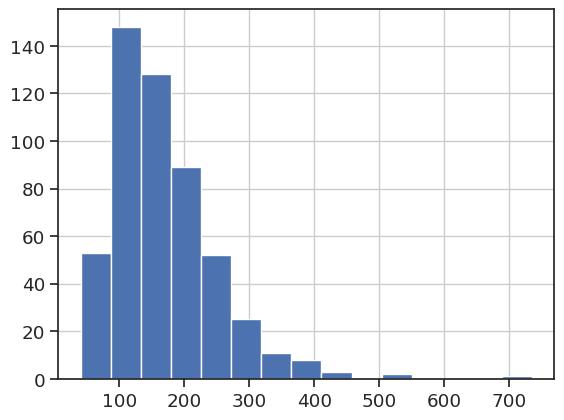

In [ ]:
# Her ses l√¶ngden af tr√¶ningssegmenterne. Antal tokens ses p√• x-aksen og antallet af forekomster p√• y-aksen.

seq_len = [len(i.split()) for i in train_texts]

pd.Series(seq_len).hist(bins = 15)

I de f√∏lgende linjer anvendes samme procedure p√• tests√¶ttet.

In [ ]:
test_label_dict = test_data.groupby('label')['segment'].apply(list).to_dict()
test_label_dict.keys()

dict_keys(['0', '1', '2', '3'])

In [ ]:
label_mapping = {
    '0': 'F√∏rmoderne',
    '1': 'Moderne',
    '2': 'Klich√©er',
    '3': 'Tvivlstilf√¶lde'}

test_label_segments_dict = {
    label_mapping.get(key, key): value for key, value in test_label_dict.items()
}
test_label_segments_dict.keys()

dict_keys(['F√∏rmoderne', 'Moderne', 'Klich√©er', 'Tvivlstilf√¶lde'])

In [ ]:
test_texts = []
test_labels = []

for _label, _segments in test_label_segments_dict.items():
    for _segment in _segments:
        test_texts.append(_segment)
        test_labels.append(_label)

len(test_texts), len(test_labels)

(130, 130)

In [ ]:
test_labels[0], test_texts[0]

('F√∏rmoderne',
 'Det er Guds Straf , ‚Äú mumlede han forf√¶rdet . ‚Äû Det anede mig nok , at det maatte ende saaledes . ‚Äú \n‚Äû Ja , I har Ret . Der synes n√¶sten at ligge et Skj√¶bnens Fingerpeg i dette . ‚Äú \n‚Äû Polichinel har altsaa opholdt sig i det tavse Palads siden den Dag , han forsvandt her fra Byen ? ‚Äú \n‚Äû Hvor l√¶nge er det siden ?')

<Axes: >

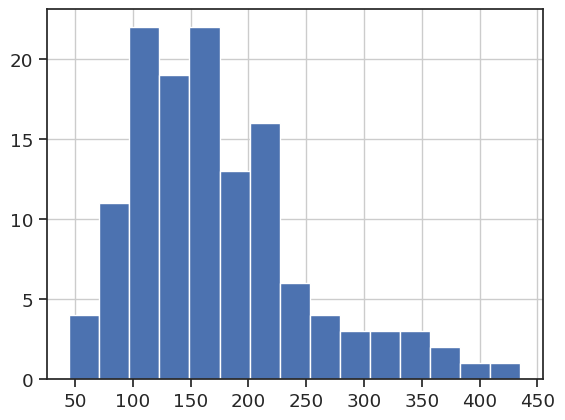

In [ ]:
seq_len = [len(i.split()) for i in test_texts]

pd.Series(seq_len).hist(bins = 15)

Her tilknyttes ID'er til etiketterne, som skal bruges til tokeniseringen af segmenterne.

In [ ]:
label2id = {label: id for id, label in enumerate(dict.fromkeys(train_labels))}
id2label = {id: label for label, id in label2id.items()}

In [ ]:
label2id.keys()

dict_keys(['F√∏rmoderne', 'Moderne', 'Klich√©er', 'Tvivlstilf√¶lde'])

In [ ]:
id2label.keys()

dict_keys([0, 1, 2, 3])

## Indl√¶s modellen


Her indl√¶ses modellen MeMo-BERT-03 via Huggingface, der er tilpasset MeMo-korpusset og 1800-tals-dansk. Se https://huggingface.co/MiMe-MeMo


In [ ]:
model_name = "MiMe-MeMo/MeMo-BERT-03"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(id2label))


Maks. l√¶ngde p√• input til modellen defineres (ud fra antal tokens), hvorefter tr√¶nings- og testss√¶ttet tokeniseres.

In [ ]:
max_length = 512

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length)

train_labels_encoded = [label2id[y] for y in train_labels]
test_labels_encoded  = [label2id[y] for y in test_labels]

In [ ]:
' '.join(train_encodings[0].tokens[0:100])

'<s> ‚ñÅDenne ‚ñÅnikkede ‚ñÅsvagt ‚ñÅ. ‚ñÅ‚Äû ‚ñÅVil ‚ñÅI ‚ñÅgive ‚ñÅmig ‚ñÅdette ‚ñÅSv√¶rd ‚ñÅ? ‚ñÅ‚Äú ‚ñÅudbr√∏d ‚ñÅKongen ‚ñÅforbavset ‚ñÅ. ‚ñÅDenne ‚ñÅGang ‚ñÅnikkede ‚ñÅden ‚ñÅGamle ‚ñÅivrig ere ‚ñÅ, ‚ñÅog ‚ñÅgjorde ‚ñÅTegn ‚ñÅtil ‚ñÅKongen ‚ñÅ, ‚ñÅaf ‚ñÅhan ‚ñÅskulde ‚ñÅb√∏ ie ‚ñÅsit ‚ñÅ√òre ‚ñÅned ‚ñÅtil ‚ñÅhans ‚ñÅBl n nd ‚ñÅ. ‚ñÅI ‚ñÅden ‚ñÅTro ‚ñÅ, ‚ñÅaf ‚ñÅden ‚ñÅGamle ‚ñÅvilde ‚ñÅgive ‚ñÅham ‚ñÅUnder retning ‚ñÅom ‚ñÅBarnets ‚ñÅSkj √¶bne ‚ñÅ, ‚ñÅlagde ‚ñÅKongen ‚ñÅsig ‚ñÅpaa ‚ñÅKn√¶ ‚ñÅved ‚ñÅhans ‚ñÅSide ‚ñÅog ‚ñÅlyttede ‚ñÅtil ‚ñÅhans ‚ñÅOrd ‚ñÅ: ‚ñÅ‚Äû ‚ñÅSt jernerne ‚ñÅhavde ‚ñÅsagt ‚ñÅmig ‚ñÅ, ‚ñÅ‚Äú ‚ñÅhviskede ‚ñÅden ‚ñÅGamle ‚ñÅn√¶ppe ‚ñÅh√∏r ligt ‚ñÅ, ‚ñÅ‚Äû ‚ñÅaf ‚ñÅI ‚ñÅvilde ‚ñÅkomme ‚ñÅtil ‚ñÅmig ‚ñÅ,'

In [ ]:
' '.join(test_encodings[0].tokens[0:100])

'<s> ‚ñÅDet ‚ñÅer ‚ñÅGuds ‚ñÅStraf ‚ñÅ, ‚ñÅ‚Äú ‚ñÅmumlede ‚ñÅhan ‚ñÅforf√¶rdet ‚ñÅ. ‚ñÅ‚Äû ‚ñÅDet ‚ñÅanede ‚ñÅmig ‚ñÅnok ‚ñÅ, ‚ñÅat ‚ñÅdet ‚ñÅmaatte ‚ñÅende ‚ñÅsaaledes ‚ñÅ. ‚ñÅ‚Äú ‚ñÅ‚Äû ‚ñÅJa ‚ñÅ, ‚ñÅI ‚ñÅhar ‚ñÅRet ‚ñÅ. ‚ñÅDer ‚ñÅsynes ‚ñÅn√¶sten ‚ñÅat ‚ñÅligge ‚ñÅet ‚ñÅSkj √¶b nens ‚ñÅFinger peg ‚ñÅi ‚ñÅdette ‚ñÅ. ‚ñÅ‚Äú ‚ñÅ‚Äû ‚ñÅPol ich in el ‚ñÅhar ‚ñÅaltsaa ‚ñÅopholdt ‚ñÅsig ‚ñÅi ‚ñÅdet ‚ñÅtavse ‚ñÅPalads ‚ñÅsiden ‚ñÅden ‚ñÅDag ‚ñÅ, ‚ñÅhan ‚ñÅforsvandt ‚ñÅher ‚ñÅfra ‚ñÅByen ‚ñÅ? ‚ñÅ‚Äú ‚ñÅ‚Äû ‚ñÅHvor ‚ñÅl√¶nge ‚ñÅer ‚ñÅdet ‚ñÅsiden ‚ñÅ? </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'

In [ ]:
set(train_labels_encoded)

{0, 1, 2, 3}

In [ ]:
set(test_labels_encoded)

{0, 1, 2, 3}

I de n√¶ste linjer kombineres de kodede etiketter og tekster til datas√¶t-objekter via torch-pakken.

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = MyDataset(train_encodings, train_labels_encoded)
test_dataset = MyDataset(test_encodings, test_labels_encoded)

In [ ]:
' '.join(train_dataset.encodings[0].tokens[0:100])

'<s> ‚ñÅDenne ‚ñÅnikkede ‚ñÅsvagt ‚ñÅ. ‚ñÅ‚Äû ‚ñÅVil ‚ñÅI ‚ñÅgive ‚ñÅmig ‚ñÅdette ‚ñÅSv√¶rd ‚ñÅ? ‚ñÅ‚Äú ‚ñÅudbr√∏d ‚ñÅKongen ‚ñÅforbavset ‚ñÅ. ‚ñÅDenne ‚ñÅGang ‚ñÅnikkede ‚ñÅden ‚ñÅGamle ‚ñÅivrig ere ‚ñÅ, ‚ñÅog ‚ñÅgjorde ‚ñÅTegn ‚ñÅtil ‚ñÅKongen ‚ñÅ, ‚ñÅaf ‚ñÅhan ‚ñÅskulde ‚ñÅb√∏ ie ‚ñÅsit ‚ñÅ√òre ‚ñÅned ‚ñÅtil ‚ñÅhans ‚ñÅBl n nd ‚ñÅ. ‚ñÅI ‚ñÅden ‚ñÅTro ‚ñÅ, ‚ñÅaf ‚ñÅden ‚ñÅGamle ‚ñÅvilde ‚ñÅgive ‚ñÅham ‚ñÅUnder retning ‚ñÅom ‚ñÅBarnets ‚ñÅSkj √¶bne ‚ñÅ, ‚ñÅlagde ‚ñÅKongen ‚ñÅsig ‚ñÅpaa ‚ñÅKn√¶ ‚ñÅved ‚ñÅhans ‚ñÅSide ‚ñÅog ‚ñÅlyttede ‚ñÅtil ‚ñÅhans ‚ñÅOrd ‚ñÅ: ‚ñÅ‚Äû ‚ñÅSt jernerne ‚ñÅhavde ‚ñÅsagt ‚ñÅmig ‚ñÅ, ‚ñÅ‚Äú ‚ñÅhviskede ‚ñÅden ‚ñÅGamle ‚ñÅn√¶ppe ‚ñÅh√∏r ligt ‚ñÅ, ‚ñÅ‚Äû ‚ñÅaf ‚ñÅI ‚ñÅvilde ‚ñÅkomme ‚ñÅtil ‚ñÅmig ‚ñÅ,'

In [ ]:
' '.join(test_dataset.encodings[0].tokens[0:100])

'<s> ‚ñÅDet ‚ñÅer ‚ñÅGuds ‚ñÅStraf ‚ñÅ, ‚ñÅ‚Äú ‚ñÅmumlede ‚ñÅhan ‚ñÅforf√¶rdet ‚ñÅ. ‚ñÅ‚Äû ‚ñÅDet ‚ñÅanede ‚ñÅmig ‚ñÅnok ‚ñÅ, ‚ñÅat ‚ñÅdet ‚ñÅmaatte ‚ñÅende ‚ñÅsaaledes ‚ñÅ. ‚ñÅ‚Äú ‚ñÅ‚Äû ‚ñÅJa ‚ñÅ, ‚ñÅI ‚ñÅhar ‚ñÅRet ‚ñÅ. ‚ñÅDer ‚ñÅsynes ‚ñÅn√¶sten ‚ñÅat ‚ñÅligge ‚ñÅet ‚ñÅSkj √¶b nens ‚ñÅFinger peg ‚ñÅi ‚ñÅdette ‚ñÅ. ‚ñÅ‚Äú ‚ñÅ‚Äû ‚ñÅPol ich in el ‚ñÅhar ‚ñÅaltsaa ‚ñÅopholdt ‚ñÅsig ‚ñÅi ‚ñÅdet ‚ñÅtavse ‚ñÅPalads ‚ñÅsiden ‚ñÅden ‚ñÅDag ‚ñÅ, ‚ñÅhan ‚ñÅforsvandt ‚ñÅher ‚ñÅfra ‚ñÅByen ‚ñÅ? ‚ñÅ‚Äú ‚ñÅ‚Äû ‚ñÅHvor ‚ñÅl√¶nge ‚ñÅer ‚ñÅdet ‚ñÅsiden ‚ñÅ? </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'

**Finjustering af BERT-modellen**

F√∏rst defineres tr√¶ningsparametrene, hvor antallet af epoker, batch-st√∏rrelse, learning rate og opvarmningstrin er justeret manuelt efter l√∏bende inspektion af resultaterne. Efterf√∏lgende defineres en evalueringsfunktion og modellen finjusteres.


In [ ]:
training_args = TrainingArguments(
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=6,
    learning_rate=3e-5,
    warmup_steps=100,
    weight_decay=1e-5,
    output_dir='./results',
    logging_dir='./logs',
    logging_steps=50,
    evaluation_strategy='steps',
    optim="adamw_torch"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of ü§ó Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

TrainOutput(global_step=390, training_loss=1.154088876186273, metrics={'train_runtime': 186.6126, 'train_samples_per_second': 8.36, 'train_steps_per_second': 2.09, 'total_flos': 410460616949760.0, 'train_loss': 1.154088876186273, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.9795740842819214,
 'eval_accuracy': 0.5923076923076923,
 'eval_runtime': 4.1352,
 'eval_samples_per_second': 31.437,
 'eval_steps_per_second': 5.32,
 'epoch': 3.0}

In [ ]:
predicted_results = trainer.predict(test_dataset)

In [ ]:
predicted_results.predictions.shape

(130, 4)

In [ ]:
predicted_labels = predicted_results.predictions.argmax(-1)
predicted_labels = predicted_labels.flatten().tolist()
predicted_labels = [id2label[l] for l in predicted_labels]

In [ ]:
len(predicted_labels)

130

Resultatet af finjusteringen inspiceres ved hj√¶lp af en klassifikationsrapport, der viser pr√¶cision, genkaldelse, F1-score og antal for hver kategori.

In [ ]:
print(classification_report(test_labels,
                            predicted_labels))

                precision    recall  f1-score   support

    F√∏rmoderne       0.71      0.55      0.62        22
      Klich√©er       0.62      0.73      0.67        55
       Moderne       0.60      0.35      0.44        17
Tvivlstilf√¶lde       0.49      0.53      0.51        36

      accuracy                           0.59       130
     macro avg       0.60      0.54      0.56       130
  weighted avg       0.60      0.59      0.59       130



Og en confusion matrix, der viser hvilke kategorier, modellen forveksler.

In [ ]:
print(confusion_matrix(test_labels,
                            predicted_labels))

[[12  5  1  4]
 [ 2 40  2 11]
 [ 0  6  6  5]
 [ 3 13  1 19]]


Inspektion af st√∏rrelsesforholdet mellem test-pr√¶diktationer og tr√¶nings-annotationer.

(array([17.,  0.,  0., 39.,  0.,  0., 64.,  0.,  0., 10.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

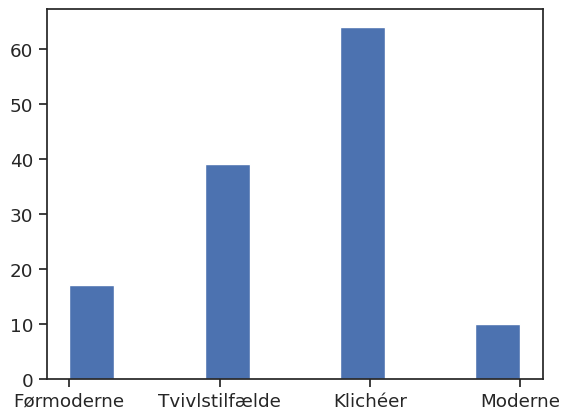

In [ ]:
plt.hist(predicted_labels)

(array([ 87.,   0.,   0.,  70.,   0.,   0., 220.,   0.,   0., 143.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

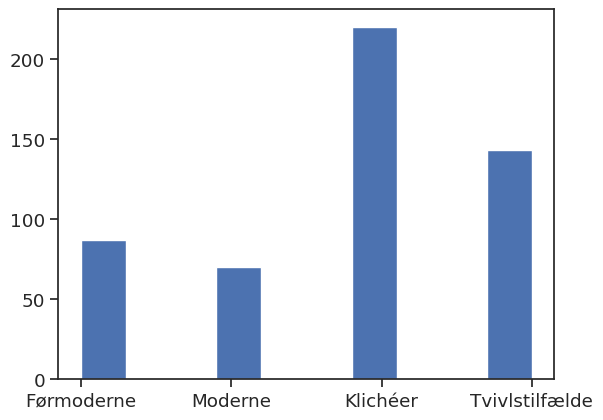

In [ ]:
plt.hist(train_labels)

In [ ]:
# Modellen gemmes
#output_dir = '/content/drive/MyDrive/Notebooks_and_data/Sk√¶bne_WSD_model'
#trainer.save_model(output_dir)

# Pr√¶diktion

Her bruges den finjusterede model til at pr√¶diktere resten af segmenterne i datas√¶ttet. F√∏rst tokeniseres inputtet, hvorefter modellen appliceres via Hugging Faces pipeline til tekstklassifikation. Resultaterne opsamles i lister med filnavne, segmenter, etiketter og score, og disse data konverteres til en pandas dataframe, som efterf√∏lgende gemmes som excel-fil.


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("MiMe-MeMo/MeMo-BERT-03")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
finetuned_model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/Notebooks_and_data/Sk√¶bne_WSD_model')

pipe = pipeline("text-classification", tokenizer=tokenizer, model=finetuned_model, framework="pt")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
dataset = Dataset.from_pandas(unlabeled_df)

In [ ]:
predictions = tqdm(pipe(KeyDataset(dataset, "segment"), truncation="only_first"))

  0%|          | 0/7442 [00:00<?, ?it/s]

In [ ]:
file_names = []
segments = []
labels = []
scores = []

for idx, label_prediction in enumerate(predictions):
    file_name = dataset[idx]["file_name"]
    segment = dataset[idx]["segment"]
    label = label_prediction["label"]
    score = label_prediction["score"]

    file_names.append(file_name)
    segments.append(segment)
    labels.append(label)
    scores.append(score)

data = {"filename": file_names, "segment": segments,"predicted label": labels,"confidence score": scores}

predictions_df = pd.DataFrame(data)

In [ ]:
# Pr√¶diktionerne gemmes
# predictions_df.to_excel('/content/drive/MyDrive/Notebooks_and_data/predictions_df.xlsx', index=False)

# Analyse

Her indl√¶ses pr√¶diktionerne, hvorefter de tilkobles udvalgt metadata og sl√•s sammen med annotationerne.

In [ ]:
predictions_df = pd.read_excel('/content/drive/MyDrive/Notebooks_and_data/predictions_df.xlsx')

In [ ]:
predictions_df_copy = predictions_df
predictions_df_copy.rename(columns={'predicted label': 'label'}, inplace=True)
predictions_df_w_metadata = predictions_df_copy.merge(metadata_df, how="left", on="filename")

labeled_df_copy = labeled_df
labeled_df_copy.rename(columns={'file_name': 'filename'}, inplace=True)

annotations_df_w_metadata = labeled_df_copy.merge(metadata_df, how="left", on="filename")

full_dataset_df = pd.concat([labeled_df_copy, predictions_df_copy], axis=0)

full_dataset_df_w_metadata = full_dataset_df.merge(metadata_df, how="left", on="filename")

In [ ]:
# V√¶rdiernes navne √¶ndres igen.

value_mapping = {
    '0': 'F√∏rmoderne',
    '1': 'Moderne',
    '2': 'Klich√©',
    '3': 'Tvivlstilf√¶lde',
    'LABEL_0': 'F√∏rmoderne',
    'LABEL_1': 'Moderne',
    'LABEL_2': 'Klich√©',
    'LABEL_3': 'Tvivlstilf√¶lde'
}

full_dataset_df_w_metadata['label'] = full_dataset_df_w_metadata['label'].replace(value_mapping)
full_dataset_df_w_metadata

In [ ]:
# Det samlede datas√¶t gemmes
# full_dataset_df_w_metadata.to_excel('/content/drive/MyDrive/Notebooks_and_data/sk√¶bne_datas√¶t.xlsx', index=False)

Inspektion af forekomster af de enkelte kategorier i datas√¶ttet.

In [ ]:
value_counts = full_dataset_df_w_metadata['label'].value_counts()
print(value_counts)

label
Klich√©            4062
Tvivlstilf√¶lde    2545
F√∏rmoderne         858
Moderne            627
Name: count, dtype: int64


Antal etiketter t√¶lles for hver roman i datas√¶ttet, og kategoriernes fordeling i de enkelte romaner beregnes i procent. Derefter kombineres b√•de de absolutte tal og procentfordelingen for en samlet oversigt.

In [ ]:
filename_label_counts = full_dataset_df_w_metadata.groupby(['filename', 'label']).size().unstack(fill_value=0)

filename_label_counts['I alt'] = filename_label_counts.sum(axis=1)

filename_label_percentages = filename_label_counts.div(filename_label_counts['I alt'], axis=0) * 100

combined_df = filename_label_counts.copy()

for col in filename_label_counts.columns:
    combined_df[col + '_percent'] = filename_label_percentages[col]

combined_df = combined_df.sort_values(by='I alt', ascending=False)

combined_df = combined_df.reset_index()

combined_df

label                                filename  F√∏rmoderne  Klich√©  Moderne  \
0            1898_RygaardHo_Kongesvaerdet.txt          56      77        2   
1          1875_SoerensenC_SkjaebnensVeie.txt          19      54        4   
2          1874_SoerensenC_KongensYndling.txt          14      68        0   
3            1880_Andersen_DenGodeAlvilda.txt           2      84        1   
4      1878_SoerensenC_AltForFaedrelandet.txt           8      55        1   
..                                        ...         ...     ...      ...   
777               1889_Vandel_Kraemmerliv.txt           0       0        0   
778           1870_Gerson_AfDetDagligeLiv.txt           0       1        0   
779      1875_EwaldHF_KnudGyldenstjerne_2.txt           0       0        0   
780            1881_Roed_HvadGunnarHoerte.txt           0       1        0   
781                1898_Raunkiaer_Memento.txt           0       0        1   

label  Tvivlstilf√¶lde  I alt  F√∏rmoderne_percent  Klich√©_percent  \
0                  33    168           33.333333       45.833333   
1                  39    116           16.379310       46.551724   
2                  19    101           13.861386       67.326733   
3                   6     93            2.150538       90.322581   
4                  22     86            9.302326       63.953488   
..                ...    ...                 ...             ...   
777                 1      1            0.000000        0.000000   
778                 0      1            0.000000      100.000000   
779                 1      1            0.000000        0.000000   
780                 0      1            0.000000      100.000000   
781                 0      1            0.000000        0.000000   

label  Moderne_percent  Tvivlstilf√¶lde_percent  I alt_percent  
0             1.190476               19.642857          100.0  
1             3.448276               33.620690          100.0  
2             0.000000               18.811881          100.0  
3             1.075269                6.451613          100.0  
4             1.162791               25.581395          100.0  
..                 ...                     ...            ...  
777           0.000000              100.000000          100.0  
778           0.000000                0.000000          100.0  
779           0.000000              100.000000          100.0  
780           0.000000                0.000000          100.0  
781         100.000000                0.000000          100.0  

[782 rows x 11 columns]

Her g√∏res det samme for forfatterskaber i stedet for romaner, men f√∏rst oprettes en ny kollonne til forfatternavn, og hvis et forfatternavn ikke er identificeret bruges et evt. pseudonym.

In [ ]:
full_dataset_df_w_metadata['author_name'] = (full_dataset_df_w_metadata['firstname'].str.strip() + ' ' + full_dataset_df_w_metadata['surname'].str.strip()).str.replace(r'\s+', ' ', regex=True)
full_dataset_df_w_metadata['author_name'].fillna(full_dataset_df_w_metadata['pseudonym'], inplace=True)

In [ ]:
filename_label_counts = full_dataset_df_w_metadata.groupby(['author_name', 'label']).size().unstack(fill_value=0)

filename_label_counts['I alt'] = filename_label_counts.sum(axis=1)

filename_label_percentages = filename_label_counts.div(filename_label_counts['I alt'], axis=0) * 100

combined_df = filename_label_counts.copy()

for col in filename_label_counts.columns:
    combined_df[col + '_percent'] = filename_label_percentages[col]

combined_df = combined_df.sort_values(by='I alt', ascending=False)

combined_df = combined_df.reset_index()

combined_df

label           author_name  F√∏rmoderne  Klich√©  Moderne  Tvivlstilf√¶lde  \
0             Carl S√∏rensen          53     325       17             133   
1              Robert Hjelm          21     130       12             116   
2               James Vend√©          38     111        4              74   
3                H.F. Ewald          17     132        6              45   
4        Claudius Albertius          34      88        1              71   
..                      ...         ...     ...      ...             ...   
327      Jens Andreas Friis           0       0        1               0   
328           Peder Thisted           0       0        1               0   
329    S. Christensen St√¶hr           0       0        0               1   
330            Peter Alsted           0       1        0               0   
331           Jakob Knudsen           0       0        1               0   

label  I alt  F√∏rmoderne_percent  Klich√©_percent  Moderne_percent  \
0        528           10.037879       61.553030         3.219697   
1        279            7.526882       46.594982         4.301075   
2        227           16.740088       48.898678         1.762115   
3        200            8.500000       66.000000         3.000000   
4        194           17.525773       45.360825         0.515464   
..       ...                 ...             ...              ...   
327        1            0.000000        0.000000       100.000000   
328        1            0.000000        0.000000       100.000000   
329        1            0.000000        0.000000         0.000000   
330        1            0.000000      100.000000         0.000000   
331        1            0.000000        0.000000       100.000000   

label  Tvivlstilf√¶lde_percent  I alt_percent  
0                   25.189394          100.0  
1                   41.577061          100.0  
2                   32.599119          100.0  
3                   22.500000          100.0  
4                   36.597938          100.0  
..                        ...            ...  
327                  0.000000          100.0  
328                  0.000000          100.0  
329                100.000000          100.0  
330                  0.000000          100.0  
331                  0.000000          100.0  

[332 rows x 11 columns]

Her t√¶lles antallet af kategorier inden for de enkelte √•r.


In [ ]:
df_grouped = full_dataset_df_w_metadata.groupby(['year', 'label']).size().unstack(fill_value=0)

df_grouped['I alt'] = df_grouped.sum(axis=1)

df_grouped = df_grouped.reset_index()

df_grouped['year'] = df_grouped['year'].astype(int)

df_grouped.columns.name = None

df_grouped

year  F√∏rmoderne  Klich√©  Moderne  Tvivlstilf√¶lde  I alt
0   1870          24     103        5              70    202
1   1871          20     151        9              67    247
2   1872           8      81        2              25    116
3   1873          15     143       10              61    229
4   1874          85     214        8             117    424
5   1875          77     327       42             204    650
6   1876          68     241       21             192    522
7   1877          40     216       19             113    388
8   1878          31     174       20             104    329
9   1879          50     214       14             126    404
10  1880          28     177       22              76    303
11  1881          15      59       18              40    132
12  1882          13     132       23              57    225
13  1883          38     170       41             113    362
14  1884           9      42        6              44    101
15  1885          16      95        8              71    190
16  1886           6      55       16              22     99
17  1887          13     125       13              40    191
18  1888          15     107       22              75    219
19  1889          12      45       18              46    121
20  1890           5      59       29              40    133
21  1891          29      85       14              46    174
22  1892          23     128       29              70    250
23  1893          13     100       14              65    192
24  1894          16     130       37             105    288
25  1895          38     125       41             112    316
26  1896          19      97       37              84    237
27  1897          22      74       15              79    190
28  1898          69     176       32             120    397
29  1899          40     213       42             157    452

Og kategorierne visualiseres med et linjediagram, der viser fordelingen af sk√¶bnekategorier gennem perioden i absolutte frekvenser.

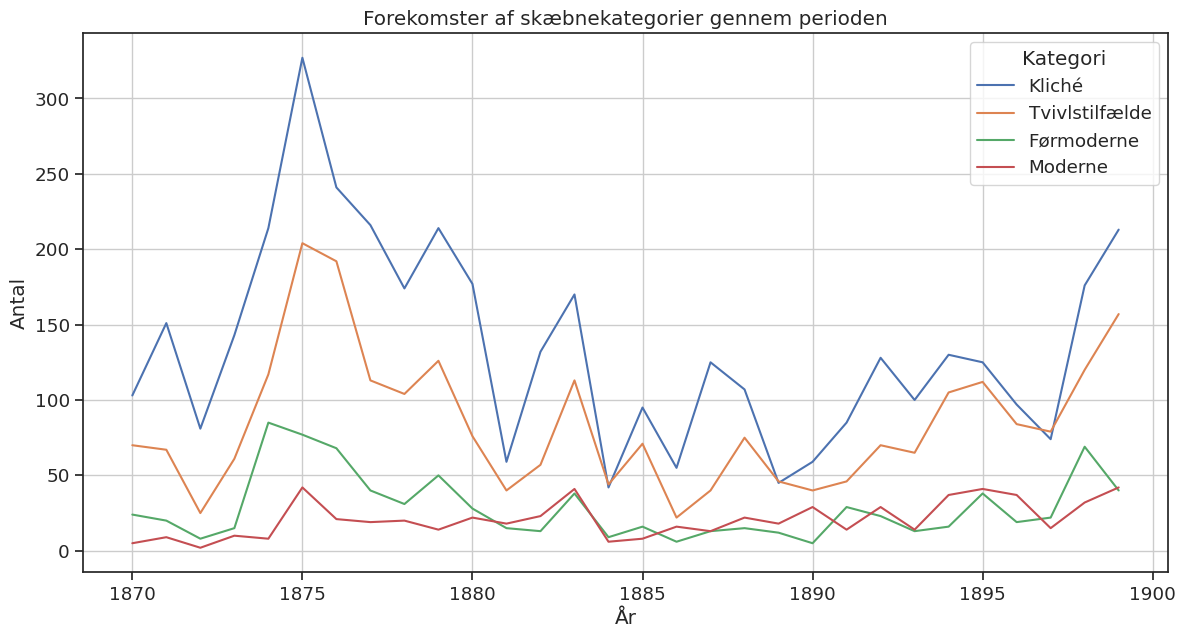

In [ ]:
max_values = df_grouped.iloc[:, 1:-1].max()

sorted_labels = max_values.sort_values(ascending=False).index

plt.figure(figsize=(14, 7))

for label in sorted_labels:
    plt.plot(df_grouped['year'], df_grouped[label], label=f'{label}')

plt.title('Forekomster af sk√¶bnekategorier gennem perioden')
plt.xlabel('√Ör')
plt.ylabel('Antal')

plt.legend(title='Kategori')
plt.grid(True)
plt.show()

Her isoleres kategorierne 'f√∏rmoderne' og 'moderne' sk√¶bneopfattelser, og deres fordeling over tid visualiseres igen med et linjediagram.

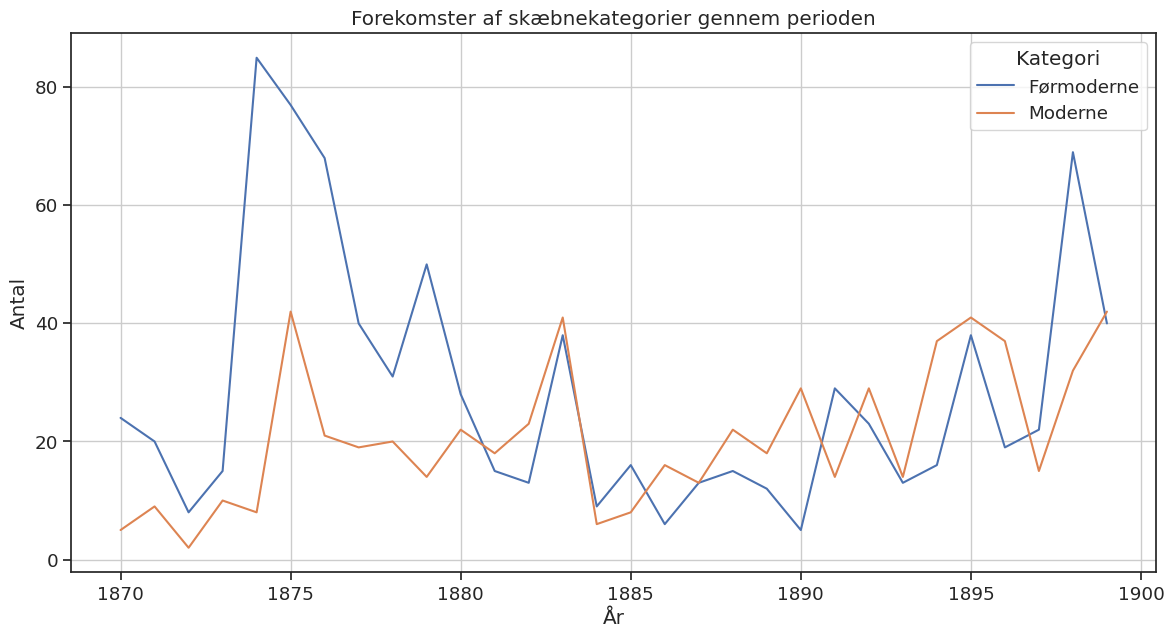

In [ ]:
df_filtered = full_dataset_df_w_metadata[full_dataset_df_w_metadata['label'].isin(['Moderne', 'F√∏rmoderne'])]

df_grouped = df_filtered.groupby(['year', 'label']).size().unstack(fill_value=0)

df_grouped = df_grouped.reset_index()

df_grouped['year'] = df_grouped['year'].astype(int)

df_grouped.columns.name = None

max_values = df_grouped.iloc[:, 1:].max()

sorted_labels = max_values.sort_values(ascending=False).index

plt.figure(figsize=(14, 7))

for label in sorted_labels:
    plt.plot(df_grouped['year'], df_grouped[label], label=label)

plt.title('Forekomster af sk√¶bnekategorier gennem perioden')
plt.xlabel('√Ör')
plt.ylabel('Antal')

plt.legend(title='Kategori')
plt.grid(True)
plt.show()